# Firing rate changes in interneurons/pyramidal during SD
- also compare it to no sleep deprivation
- should account for unstable cells, these maybe causing increased firing rate toward ZT5 in NSD sessions 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from neuropy.plotting import Fig
import subjects

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]

Text(0.5, 0.98, 'Firing rate changes first five hours of POST')

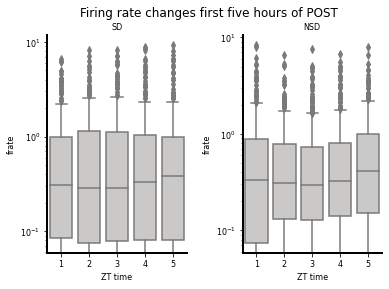

In [2]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,2),size=(6,4),wspace=0.4)
for sess_ind, sessions in enumerate([sessions_sd,sessions_nsd]):
    data = pd.DataFrame()
    for sub, sess in enumerate(sessions):
        # print(sub)
        pre = sess.paradigm['pre']
        post = sess.paradigm['post']
        neurons = sess.neurons.get_neuron_type('pyr')
        spktrns = neurons.spiketrains
        sd_bins = np.arange(6)*3600 + post[0]
        frate = np.asarray([np.histogram(spk,bins=sd_bins)[0] for spk in spktrns ])/3600
        # frate= np.log10(frate)
        mean_frate = np.mean(frate,axis=0)
        data = data.append(pd.DataFrame({'frate':frate.flatten(),'bins':list(np.arange(1,6))*frate.shape[0]}))

    ax = plt.subplot(gs[sess_ind])
    sns.boxplot(data=data,x='bins',y='frate',color='#ccc7c7',ax=ax)
    # sns.swarmplot(data=data,x='bins',y='frate',color='k',ax=ax)
    ax.set_xlabel('ZT time')
    ax.set_title(f"{'SD' if sess_ind==0 else 'NSD'}")
    ax.set_yscale('log')

fig.suptitle('Firing rate changes first five hours of POST')

# Firing rate changes across session in SD and compare with NSD

Kamran's comment as observed from Miyawaki and Diba 2016 (Fig 1C)
> The animal is put on the track at 6am, and firing rates shoot up. In POST (next day’s light cycle) they start to come down. What happens to these firing rates in SD? In SD before Track, are they also high, or does it require TRack running?  And in NSD after track, do they come down, compared to SD after track?

The analysis below is for assesing that

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from neuropy.plotting import Fig
import subjects


In [ ]:
%matplotlib widget
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(4,4))
sessions = subjects.Sd().allsess + subjects.Nsd().allsess
data = pd.DataFrame()
for sub, sess in enumerate(sessions):

    tag = sess.recinfo.animal.tag
    try:
        maze = sess.epochs.maze
    except:
        maze = sess.epochs.maze1

    pre = sess.epochs.pre
    post = sess.epochs.post
    cells = sess.spikes.pyr

    pre_bins,pre_binsz = np.linspace(pre[0],pre[1],2,retstep=True)
    frate_pre = np.asarray([np.histogram(cell,bins=pre_bins)[0] for cell in cells])/pre_binsz

    maze_bins,maze_binsz = np.linspace(maze[0],maze[1],2,retstep=True)
    frate_maze = np.asarray([np.histogram(cell,bins=maze_bins)[0] for cell in cells])/maze_binsz

    sd_bins,sd_binsz = np.linspace(post[0],post[0]+5*3600,2,retstep=True)
    frate_sd = np.asarray([np.histogram(cell,bins=sd_bins)[0] for cell in cells])/sd_binsz


    post_bins,post_binsz = np.linspace(post[0]+5*3600,post[1],2,retstep=True)
    frate_post = np.asarray([np.histogram(cell,bins=post_bins)[0] for cell in cells])/post_binsz

    frate = np.hstack((frate_pre,frate_maze,frate_sd,frate_post))

    # frate= np.log10(frate)
    # mean_frate = np.mean(frate,axis=0)
    data = data.append(pd.DataFrame({'frate':frate.flatten(),'bins':list(np.arange(1,frate.shape[1]+1))*frate.shape[0]}))

data_mean = data.groupby('bins').mean()
data_sem = data.groupby('bins').sem(ddof=0)

ax = plt.subplot(gs[0])
# sns.lineplot(data=data,x='bins',y='frate',color='#ccc7c7',ax=ax,err_style='bars',ci=68)
ax.errorbar(data_mean.index.values,data_mean['frate'],yerr=data_sem['frate'],capsize=3,lw=2,color='k')
ax.axvspan(1,7,0,0.05,color='#968d8d')
ax.axvspan(7,16,0,0.05,color='#fadf80')
# ax.axvspan(7,16,0,0.05,color='#de5454')
# ax.axvspan(10,16,0,0.05,color='#de5454')
# sns.swarmplot(data=data,x='bins',y='frate',color='k',ax=ax)
ax.set_xlabel('ZT (SD period)')
ax.set_title('Firing rating changes across entire session')
ax.set_ylim([0.2,1])


In [ ]:
sess = subjects.Of().ratNday4[0]
sess.tracks.plot(["maze"])


# Pbe rate change across sleep deprivation

In [ ]:
import numpy as np
import subjects

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
)


In [ ]:
%matplotlib widget
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame()
for sub, sess in enumerate(sessions):

    # sd = sess.paradigm['sd']
    post = sess.paradigm['post']
    sd = [post[0],post[0]+5*3600]
    pbe_sd = sess.pbe.time_slice(sd[0],sd[1])
    bin_size= 600
    sd_bin = np.arange(sd[0],sd[1]+bin_size,bin_size)
    hist_pbe = np.histogram(pbe_sd.starts,bins=sd_bin)[0]

    df = df.append(pd.DataFrame({'n_pbe':hist_pbe/bin_size,'tbin':(sd_bin[:-1]-sd_bin[0])/3600,'sub':sub}))


pbe_mean = df.groupby('tbin').mean().n_pbe
pbe_sem= df.groupby('tbin').sem(ddof=0).n_pbe

fig,ax = plt.subplots()
# sns.lineplot(data=df,x='tbin',y='n_pbe')
ax.fill_between(pbe_mean.index,pbe_mean-pbe_sem,pbe_mean+pbe_sem,alpha=0.5)
ax.plot(pbe_mean.index,pbe_mean)
ax.set_xlabel('Zt time')
ax.set_ylabel('PBE rate (Hz)')

# Combined neuron type

In [ ]:
import subjects
import numpy as np
from neuropy.utils import neurons_util

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
)


In [ ]:
%matplotlib widget
neurons=[]
for sess in sessions:
    neurons.append(sess.neurons)

neuron_type= neurons_util.estimate_neuron_type(neurons)

for sub,sess in enumerate(sessions):
    sess.neurons.neuron_type = neuron_type[sub]
    sess.neurons.filename = sess.filePrefix.with_suffix('.neurons')
    sess.neurons.save()

# Firing rate change at NREM-REM transition during recovery sleep vs regular sleep
There can be two ways to look at the changes in firing rate
- mua firing rate (but it does not make sense, as high firing rate neurons can blur the changes)
- normalize/zscore each neurons firing rate during transition and then calculate the mean across neurons 
    - firing rate increase towards the end of NREM and decrese during following REM. This is consistent with Miyawaki and Diba (2016)

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]


In [ ]:
df = pd.DataFrame()
binsz = 2
for sess_ind, sessions in enumerate([sessions_sd, sessions_nsd]):
    grp = "sd" if sess_ind == 0 else "nsd"
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"]
        pyr = sess.neurons.get_neuron_type("pyr")
        rec_slp = [post[0] + 5 * 3600, post[1]]
        states = sess.brainstates.time_slice(rec_slp[0], rec_slp[1]).to_dataframe()
        labels = states.label.values

        for i in range(len(labels) - 1):
            if (labels[i] == "nrem") and (labels[i + 1] == "rem"):

                # ---- MUA -----
                # nrem_mua = pyr.get_mua(t_start=states.iloc[i].start,t_stop=states.iloc[i].stop,bin_size=4)
                # rem_mua = pyr.get_mua(t_start=states.iloc[i+1].start,t_stop=states.iloc[i+1].stop,bin_size=4)
                # frate = np.hstack((nrem_mua.spike_counts,rem_mua.spike_counts))
                # bins = np.arange(-nrem_mua.n_bins,rem_mua.n_bins)

                # --- zscored firing rate ---------
                nrem_binspk = pyr.get_binned_spiketrains(
                    t_start=states.iloc[i].start,
                    t_stop=states.iloc[i].stop,
                    bin_size=binsz,
                )
                rem_binspk = pyr.get_binned_spiketrains(
                    t_start=states.iloc[i + 1].start,
                    t_stop=states.iloc[i + 1].stop,
                    bin_size=binsz,
                )
                bins = np.arange(-nrem_binspk.n_bins, rem_binspk.n_bins)
                frate = np.nanmean(
                    stats.zscore(
                        np.hstack((nrem_binspk.spike_counts, rem_binspk.spike_counts)),
                        axis=1,
                    ),
                    axis=0,
                )

                df = df.append(pd.DataFrame({"bins": bins, "frate": frate, "grp": grp}))


In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(5,4),style='Pres')
ax = plt.subplot(gs[0])
df_ = df.groupby('grp')
color = ['r','k']
for i,grp in enumerate(['sd','nsd']):
    grp_df = df_.get_group(grp)
    mean_frate = grp_df.groupby('bins').mean().frate
    sem_frate = grp_df.groupby('bins').sem(ddof=0).frate
    ax.fill_between(mean_frate.index.values,mean_frate-sem_frate,mean_frate+sem_frate,color=color[i],alpha=0.3,ec=None)
    ax.plot(mean_frate.index.values,mean_frate,color=color[i],alpha=0.6)
    # ax.errorbar(mean_frate.index,mean_frate, yerr=sem_frate,color=color[i],capsize=3,elinewidth=1,errorevery=1)
    # ax = sns.lineplot(data=df,x='bins',y='mua',ci='sd')

ax.legend(['sd rec. slp.','nsd'])
ax.axvline(x=0,ls='--')
ax.set_xlim([-50,30])
ax.set_ylim([-0.4,0.4])
ax.set_title('NREM-REM transition')
ax.set_ylabel('Normalized firing rate')
ax.set_xlabel('Time bin from start of REM')
figure.savefig('nrem-rem_transition_frate_sd_vs_nsd',folder='/home/bapung/Documents/figures')


# Firing rate changes within NREM during and SD and compare with NSD
- Firing rate first decreases and then increases ? Not consistent with Miyawaki and Diba 2016 ?

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]
print(sessions_sd,sessions_nsd)


In [ ]:
df = pd.DataFrame()
for sess_ind, sessions in enumerate([sessions_sd, sessions_nsd]):
    grp = "sd" if sess_ind == 0 else "nsd"
    for sub, sess in enumerate(sessions):
        post = sess.paradigm["post"]
        pyr = sess.neurons.get_neuron_type("pyr")
        rec_slp = [post[0] + 5 * 3600, post[1]]
        states = sess.brainstates.time_slice(rec_slp[0], rec_slp[1]).to_dataframe()
        labels = states.label.values
        nrems = states[(states["label"] == "nrem") & (states["duration"] > 240)]

        for nrem in nrems.itertuples():

            bins, binsz = np.linspace(nrem.start, nrem.stop, 10, retstep=True)

            nrem_binspk = pyr.get_binned_spiketrains(
                t_start=nrem.start, t_stop=nrem.stop, bin_size=binsz
            )

            frate = np.nanmean(stats.zscore(nrem_binspk.spike_counts, axis=1), axis=0)

            df = df.append(
                pd.DataFrame(
                    {"bins": np.linspace(0,1,nrem_binspk.n_bins), "frate": frate, "grp": grp}
                )
            )

In [ ]:
%matplotlib inline
figure = Fig()
fig,gs = figure.draw(grid=(1,1),size=(5,4),style='Pres')
ax = plt.subplot(gs[0])
df_ = df.groupby('grp')
color = ['#26507e','#79a7d7']
z=1
for i,grp in enumerate(['sd','nsd']):
    grp_df = df_.get_group(grp)
    mean_frate = grp_df.groupby('bins').mean().frate
    sem_frate = grp_df.groupby('bins').sem(ddof=0).frate
    ax.fill_between(mean_frate.index.values,mean_frate-sem_frate,mean_frate+sem_frate,color=color[i],alpha=0.3,ec=None,zorder=z)
    ax.plot(mean_frate.index.values,mean_frate,color=color[i],zorder=z+1)
    # ax.errorbar(mean_frate.index,mean_frate, yerr=sem_frate,color=color[i],capsize=3,elinewidth=1,errorevery=1)
    # ax = sns.lineplot(data=df,x='bins',y='mua',ci='sd')
    z+=2

ax.legend(['sd rec. slp.','nsd'])
ax.set_title('Firing rate changes within NREM')
ax.set_ylabel('Normalized firing rate')
ax.set_xlabel('Time bin from start of NREM')
figure.savefig(subjects.fig_folder/'nrem-rem_transition_frate_sd_vs_nsd')

# Firing rate changes across sleep deprivation individual neurons or quantiles
- something simiilar to firing rate homeostasis

In [ ]:
import numpy as np
from scipy import stats
import subjects
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from neuropy.plotting import Fig

sessions_sd = subjects.sd.allsess
sessions_nsd = subjects.nsd.allsess[:-1]
print(sessions_sd,sessions_nsd)

In [ ]:
bin_size = 60
for sub,sess in enumerate(sessions_sd[2:3]):
    post = sess.paradigm['post']
    sd= [post[0],post[0]+5*3600]
    neurons =sess.neurons.get_neuron_type('pyr').time_slice(t_start=sd[0],t_stop=sd[1])
    binspk = neurons.get_binned_spiketrains(bin_size=bin_size)
    zsc_binspk = stats.zscore(binspk.spike_counts/bin_size,axis=1)

In [ ]:
%matplotlib widget
plt.plot(zsc_binspk[5:10,:].T)
# plt.yscale('log')